Previous iterations of PA-NODE fails to learn 

In [2]:
# Import the necessary packages:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
#import Plot3D as plot3d

#Neural ODE library
import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Generating Data

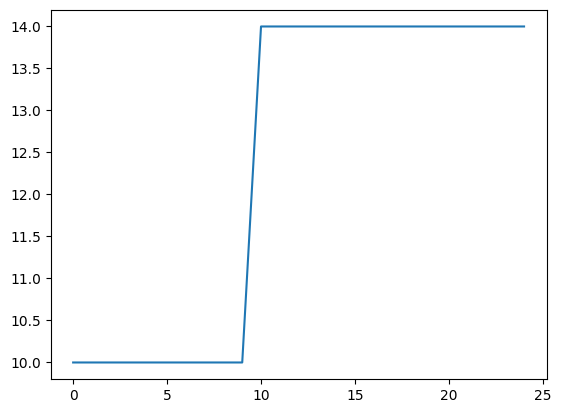

In [3]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [10.0, 14.0]
def rho(t, r_vals = r_vals, step = 10):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [4]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.05
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 15)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(1, 300, 2, 3)

### Normalizing Data

In [5]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

## Plotting 

In [6]:
data_norm.shape

(1, 300, 2, 3)

In [7]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

    

In [8]:
data_norm[0, :, 0, 0].shape

(300,)

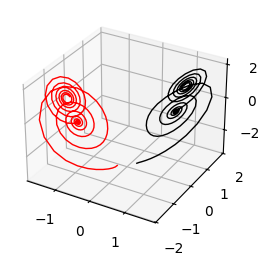

In [9]:

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   



# Training Neural ODE

In [10]:
model = nodes.Piecewise_Auto_NODE(spatial_dim=3, depth=2, width = 30, time_range=[0, 15], num_breakpoints=1, activation_func=nn.Tanh())

In [12]:
model.break_params = torch.nn.Parameter(torch.tensor([10.0]), requires_grad=True)

In [15]:
#Saving loss and setting optimiser 
loss_list = []
break_param_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
#t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [14]:
times = np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])
t_eval_tensor = torch.tensor(times)
t_eval_tensor.shape

torch.Size([1, 300])

## Single Loop 

In [16]:
#Single training loop
optimizer.zero_grad()

pred_x_list = []
for i in range(t_eval_tensor.shape[0]):

    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor.float())

train_loss.backward()
optimizer.step()
break_param_list.append(model.break_params.detach().numpy())

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(4.3601, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([0.1700])



## Main Training Loop

In [18]:
def batch(data: torch.tensor, t: torch.tensor, batch_length: int, num_batch: int): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).

    Modifed to allow for multiple time spans

    Parameters:
    -----------       
    data : torch.tensor
        The full dataset from which to sample batches. (num_time_spans, time, traj, dim)

    t : torch.tensor
        The corresponding time tensor. (num_time_spans, time)
    '''
    data_length = data.shape[1]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[:, ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[:, ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))
        
        #Each batch has shape (num_time_spans, batch_length, traj, dim) and each batch time has shape (num_time_spans, batch_length)

        return batch_list, batch_time_list

In [19]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [20]:
batch_length = 20
num_batch = 15
num_epochs = 1000

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     
    
   

  0%|          | 1/1000 [00:03<56:43,  3.41s/it]

Epoch 0, Loss: 2.9847729206085205


  2%|▏         | 21/1000 [01:01<49:08,  3.01s/it]

Epoch 20, Loss: 0.7955393195152283


  4%|▍         | 41/1000 [01:57<46:51,  2.93s/it]

Epoch 40, Loss: 0.7006112933158875


  6%|▌         | 61/1000 [02:56<46:19,  2.96s/it]

Epoch 60, Loss: 0.6552719473838806


  8%|▊         | 81/1000 [03:52<44:34,  2.91s/it]

Epoch 80, Loss: 0.6912959814071655


 10%|█         | 101/1000 [04:47<43:42,  2.92s/it]

Epoch 100, Loss: 0.7465981841087341


 12%|█▏        | 121/1000 [05:42<40:44,  2.78s/it]

Epoch 120, Loss: 0.5218489766120911


 14%|█▍        | 141/1000 [06:37<41:09,  2.88s/it]

Epoch 140, Loss: 0.6031400561332703


 16%|█▌        | 161/1000 [07:33<40:21,  2.89s/it]

Epoch 160, Loss: 0.5831446051597595


 18%|█▊        | 181/1000 [08:28<37:46,  2.77s/it]

Epoch 180, Loss: 0.42755013704299927


 20%|██        | 201/1000 [09:23<37:37,  2.83s/it]

Epoch 200, Loss: 0.432697594165802


 22%|██▏       | 221/1000 [10:18<37:26,  2.88s/it]

Epoch 220, Loss: 0.3385286331176758


 24%|██▍       | 241/1000 [11:13<36:06,  2.85s/it]

Epoch 240, Loss: 0.3155186176300049


 26%|██▌       | 261/1000 [12:10<38:27,  3.12s/it]

Epoch 260, Loss: 0.30782097578048706


 28%|██▊       | 281/1000 [13:08<37:03,  3.09s/it]

Epoch 280, Loss: 0.32357943058013916


 30%|███       | 301/1000 [14:14<46:16,  3.97s/it]

Epoch 300, Loss: 0.3028300404548645


 32%|███▏      | 321/1000 [15:42<51:36,  4.56s/it]

Epoch 320, Loss: 0.30826252698898315


 34%|███▍      | 341/1000 [17:04<37:24,  3.41s/it]

Epoch 340, Loss: 0.31350451707839966


 36%|███▌      | 361/1000 [18:16<48:28,  4.55s/it]

Epoch 360, Loss: 0.3008098602294922


 38%|███▊      | 381/1000 [19:42<39:06,  3.79s/it]

Epoch 380, Loss: 0.2952633202075958


 40%|████      | 401/1000 [21:18<57:20,  5.74s/it]

Epoch 400, Loss: 0.2895483672618866


 42%|████▏     | 421/1000 [22:36<41:56,  4.35s/it]

Epoch 420, Loss: 0.2924741208553314


 44%|████▍     | 441/1000 [23:48<34:03,  3.66s/it]

Epoch 440, Loss: 0.27635475993156433


 46%|████▌     | 461/1000 [25:00<32:59,  3.67s/it]

Epoch 460, Loss: 0.296522319316864


 48%|████▊     | 481/1000 [26:12<31:58,  3.70s/it]

Epoch 480, Loss: 0.2772354781627655


 50%|█████     | 501/1000 [27:46<47:27,  5.71s/it]

Epoch 500, Loss: 0.28090256452560425


 52%|█████▏    | 520/1000 [29:28<27:12,  3.40s/it]


KeyboardInterrupt: 

In [21]:
model.break_params

Parameter containing:
tensor([8.7415], requires_grad=True)

## Plotting results

Text(0.5, 0, 'Epochs')

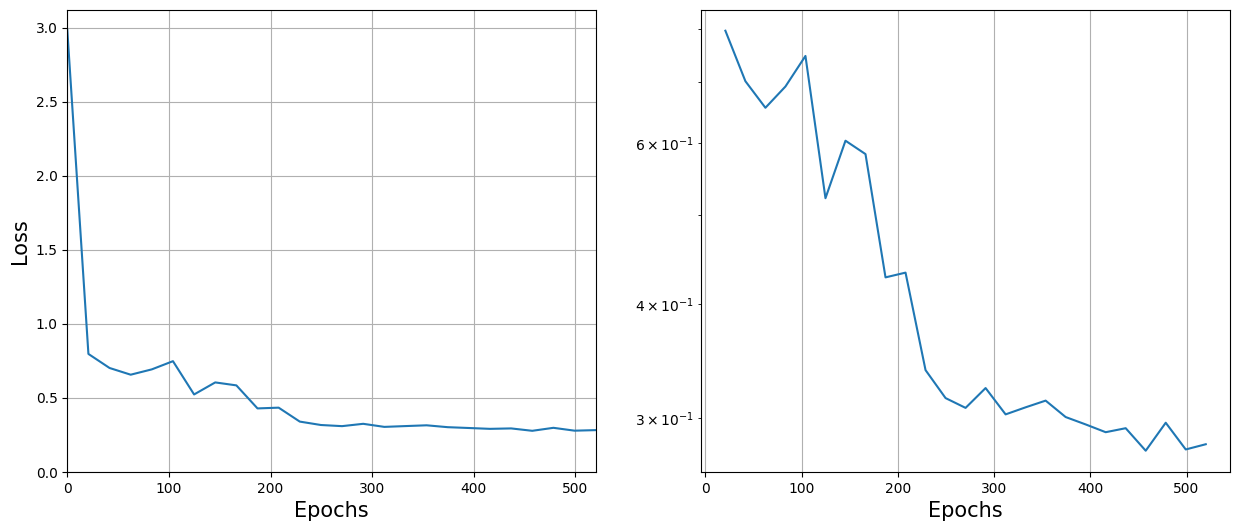

In [22]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [23]:
t_Start_pred = 0; t_Final_pred = 15
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

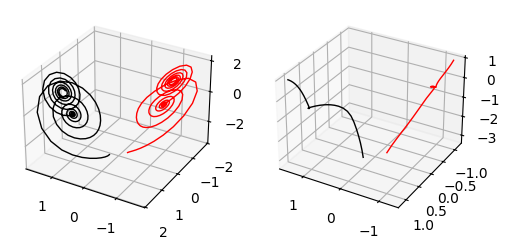

In [24]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()

In [52]:

def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[0, :index, 0, 0], ys=data_norm[0, :index, 0, 1], zs=data_norm[0, :index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[0, :index, 1, 0], ys=data_norm[0, :index, 1, 1], zs=data_norm[0, :index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

In [53]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[0, :index, 0, 0], ys=training_data_tensor[0, :index, 0, 1], zs=training_data_tensor[0, :index, 0, 2], color = 'black', linewidth = 1 )
        ax1.plot(xs=training_data_tensor[0, :index, 1, 0], ys=training_data_tensor[0, :index, 1, 1], zs=training_data_tensor[0, :index, 1, 2], color = 'red', linewidth = 1 )

        #ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
        ax1.view_init(elev = 30, azim = 120)


        #Second Plot 
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(xs=node_data[:index, 0, 0].detach().numpy(), ys=node_data[:index, 0, 1].detach().numpy(), zs=node_data[:index, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
        ax2.plot(xs=node_data[:index, 1, 0].detach().numpy(), ys=node_data[:index, 1, 1].detach().numpy(), zs=node_data[:index, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

        ax2.view_init(elev = 30, azim = 120)



In [47]:
node_data.shape

torch.Size([500, 2, 3])

In [48]:
model.break_params

Parameter containing:
tensor([8.2038], requires_grad=True)

In [54]:

interact(plot_interact2, index=IntSlider(min=0, max=500, step=1))

interactive(children=(IntSlider(value=0, description='index', max=500), Output()), _dom_classes=('widget-inter…

<function __main__.plot_interact2(index)>

## Bifurcation Diagram

In [ ]:
a = 1

In [ ]:
np.vectorize(lorenz.f)

In [ ]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




In [ ]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
